In [ ]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

!pip install mord
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns

!pip install dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=892ef651fef40ecd7b5b3e8ca157a21aa99bf61f228f89c1b2c023bd326267e1
  Stored in directory: /root/.cache/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord
     |████████████████████████████████| 11.8 MB 14.7 MB/s 
no display found. Using non-interactive Agg backend


## Universal Bank
Load the `UniversalBank.csv` dataset. The columns `ID` and `ZIP Code` are not relevant for model building and therefore removed. Treat Education as categorical

In [ ]:
bank = pd.read_csv('UniversalBank.csv')
bank.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [ ]:
bank.drop(columns = ['ID','ZIP Code'],inplace=True)

In [ ]:
bank.columns = [c.replace(' ','_') for c in bank.columns]

In [ ]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   Family              5000 non-null   int64  
 4   CCAvg               5000 non-null   float64
 5   Education           5000 non-null   int64  
 6   Mortgage            5000 non-null   int64  
 7   Personal_Loan       5000 non-null   int64  
 8   Securities_Account  5000 non-null   int64  
 9   CD_Account          5000 non-null   int64  
 10  Online              5000 non-null   int64  
 11  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 468.9 KB


In [ ]:
bank['Education'] = bank['Education'].astype('category')
new_cate = {1:'undergrad',
            2:'graduate',
            3:'professional'}
bank.Education.cat.rename_categories(new_cate,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [ ]:
bank.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,undergrad,0,0,1,0,0,0
1,45,19,34,3,1.5,undergrad,0,0,1,0,0,0
2,39,15,11,1,1.0,undergrad,0,0,0,0,0,0
3,35,9,100,1,2.7,graduate,0,0,0,0,0,0
4,35,8,45,4,1.0,graduate,0,0,0,0,0,1


In [ ]:
bank = pd.get_dummies(bank,prefix_sep='_',drop_first=True) 

In [ ]:
bank.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_graduate,Education_professional
0,25,1,49,4,1.6,0,0,1,0,0,0,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,1,0


## Universal bank probabilities
Predict to get the probabilities

In [ ]:
X = bank.drop(columns='Personal_Loan')
y = bank['Personal_Loan']

train_X, valid_X, train_y, valid_y = train_test_split(X,y,test_size=.4,random_state=1)

In [ ]:
from scipy.sparse.construct import rand
logit_reg = LogisticRegression(solver='liblinear', C=1e42, random_state=1)
logit_reg.fit(train_X,train_y)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [ ]:
logit_reg.intercept_

array([-12.12625911])

In [ ]:
logit_reg.coef_

array([[-5.08786771e-02,  5.21590455e-02,  5.86883455e-02,
         6.09664454e-01,  2.40296329e-01,  1.00896463e-03,
        -1.03195380e+00,  3.65849972e+00, -6.81390010e-01,
        -9.57569248e-01,  4.20100938e+00,  4.35528428e+00]])

In [ ]:
print(pd.DataFrame({'coef':logit_reg.coef_[0]},index=X.columns))

                            coef
Age                    -0.050879
Experience              0.052159
Income                  0.058688
Family                  0.609664
CCAvg                   0.240296
Mortgage                0.001009
Securities_Account     -1.031954
CD_Account              3.658500
Online                 -0.681390
CreditCard             -0.957569
Education_graduate      4.201009
Education_professional  4.355284


In [ ]:
coeffdf = pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns)
coeffdf['odds'] = np.e**coeffdf['coef']
coeffdf

,coef,odds
Age,-0.050879,0.950394
Experience,0.052159,1.053543
Income,0.058688,1.060445
Family,0.609664,1.839814
CCAvg,0.240296,1.271626
Mortgage,0.001009,1.001009
Securities_Account,-1.031954,0.356310
CD_Account,3.658500,38.803084
Online,-0.681390,0.505913
CreditCard,-0.957569,0.383825


In [ ]:
logit_reg_prob = logit_reg.predict_proba(valid_X)

In [ ]:
logit_reg_pred = logit_reg.predict(valid_X)

In [ ]:
logit_result = pd.DataFrame({'actual':valid_y,
                             'p_0':[p[0] for p in logit_reg_prob],
                             'p_1':[p[1] for p in logit_reg_prob],
                             'predicted':logit_reg_pred})
logit_result

,actual,p_0,p_1,predicted
2764,0,0.975937,0.024063,0
4767,0,0.999938,0.000062,0
3814,0,0.999898,0.000102,0
3499,0,0.998407,0.001593,0
2735,0,0.956225,0.043775,0
...,...,...,...,...
4372,0,0.996092,0.003908,0
3401,0,0.999631,0.000369,0
1239,0,0.999785,0.000215,0
437,0,0.998503,0.001497,0


In [ ]:
classificationSummary(train_y,logit_reg.predict(train_X))

Confusion Matrix (Accuracy 0.9607)

       Prediction
Actual    0    1
     0 2685   28
     1   90  197


In [ ]:
classificationSummary(valid_y,logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128


## Universal Bank Gains Chart

In [ ]:
df = logit_result.sort_values(by='p_1',ascending=False)
df

,actual,p_0,p_1,predicted
3373,1,0.000575,0.999425,1
2217,1,0.000866,0.999134,1
787,1,0.001103,0.998897,1
47,1,0.002364,0.997636,1
3006,1,0.002462,0.997538,1
...,...,...,...,...
1100,0,0.999997,0.000003,0
4922,0,0.999997,0.000003,0
1720,0,0.999997,0.000003,0
3125,0,0.999998,0.000002,0


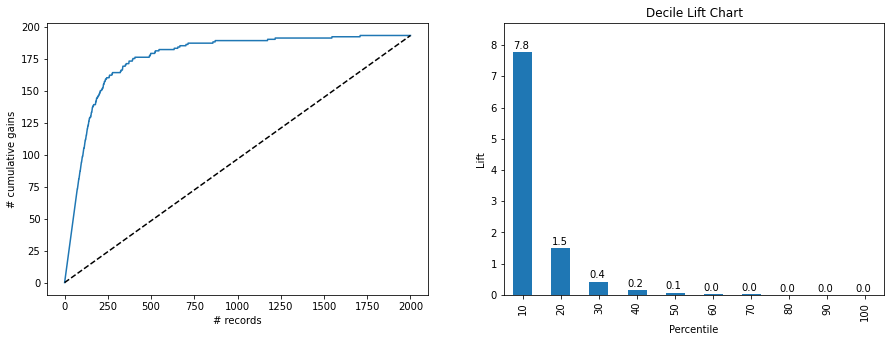

In [ ]:
fig, axes = plt.subplots(1,2, figsize=[15,5])
gainsChart(df.actual,ax=axes[0])
liftChart(df['p_1'],ax=axes[1])